# Boosted Decision Tree
Use 30% of the data to train a BDT

In [3]:
import uproot
import boost_histogram as bh
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import awkward as ak

In [4]:
def get_config(is_jaguar=False):
    config = dict()
    config["data"] = dict()
    if is_jaguar:
        config["data"] = {
            "files" : "/storage/cpegueros/tau2pipi0_taupair_1623721564_00/sub00/cuts30/*.root",
            "workers" : 45,
            "step_size" : "500 MB",
        }
        config["tree_dir"] = "/home/cpegueros/bdt/"
        config["tree_to_use"] = "/home/cpegueros/bdt/gradient_1627111793.joblib"
        config["data_classified"] = "/storage/cpegueros/data_classified.csv"
    else:
        config["data"] = {
            "files" : None,
            "workers" : None,
            "step_size" : None,
        }
        config["tree_dir"] = None
        # este BDT es el bueno
        config["tree_to_use"] = "/home/peguerosdc/development/thesis/data/gradient_1627111793.joblib"
        config["data_classified"] = "/home/peguerosdc/development/thesis/data/data_classified.csv"
    return config

In [5]:
# set variables to use
branches_to_train = ["thrust","visibleEnergyOfEventCMS","track_sig_EoverP","track_sig_pionID","track_sig_pt", "sig_gamma1_E","sig_gamma2_E","track_sig_cosToThrustOfEvent","neutral_sig_E","neutral_sig_M"]
branches_to_cut = ["tauPlusMCMode", "tauMinusMCMode", "track_sig_charge", "tau_sig_InvM", "nPi0s_sig", "tau_sig_matchedMC_InvM"]
branches_to_use = branches_to_train + branches_to_cut
print(f"Going to use {len(branches_to_train)} variables to fit...")

Going to use 10 variables to fit...


Read the data to create the dataset (takes around 287s)

In [4]:
# choose files
config = get_config(is_jaguar=True)

# read with cuts using ak
signal_temp = ak.Array([])
bg_temp = ak.Array([])
for df in uproot.iterate(f"{config['data']['files']}:tau1x1", filter_name=branches_to_use,step_size=config['data']['step_size'], num_workers=config['data']['workers']):
    one_pi0 = df[(df.nPi0s_sig==1)]
    # get the events that are signal
    is_signal = \
    (( (one_pi0.track_sig_charge==1) & (one_pi0.tauPlusMCMode==4) ) | (
        (one_pi0.track_sig_charge==-1) & (one_pi0.tauMinusMCMode==4)
    ))
    signal_temp = ak.concatenate([signal_temp, one_pi0[is_signal]], axis=0)
    # get the events that are background
    is_bg = \
        (( (one_pi0.track_sig_charge==1) & (one_pi0.tauPlusMCMode!=4) ) | (
            (one_pi0.track_sig_charge==-1) & (one_pi0.tauMinusMCMode!=4)
        ))
    bg_temp = ak.concatenate([bg_temp, one_pi0[is_bg]], axis=0)
# convert everything to pandas
signal = ak.to_pandas(signal_temp).drop(columns=["nPi0s_sig"])
signal["is_signal"] = 1
print(f"Signal events       :  {len(signal)}")
background = ak.to_pandas(bg_temp).drop(columns=["nPi0s_sig"])
background["is_signal"] = 0
print(f"Background events   :  {len(background)}")
# concat all in one data set and save it
data = pd.concat([signal, background], ignore_index=True)
data.to_csv(config["data_classified"])
print(f"Data saved at {config['data_classified']}")
data

Signal events       :  1650061
Background events   :  528058
Data saved at /storage/cpegueros/data_classified.csv


,thrust,visibleEnergyOfEventCMS,tauMinusMCMode,tauPlusMCMode,tau_sig_InvM,tau_sig_matchedMC_InvM,neutral_sig_E,neutral_sig_M,track_sig_pt,track_sig_charge,track_sig_cosToThrustOfEvent,track_sig_EoverP,track_sig_pionID,sig_gamma1_E,sig_gamma2_E,is_signal
0,0.850522,1.474828,3.0,4.0,0.808521,0.855973,0.698558,0.128000,0.671802,1.0,0.841184,0.434246,1.000000,0.414465,0.284093,1
1,0.968179,2.802266,1.0,4.0,0.688970,0.689086,1.275417,0.137439,1.019209,1.0,-0.951703,0.187453,0.999286,0.258614,1.016802,1
2,0.914588,1.468927,4.0,2.0,0.657552,0.693965,0.355679,0.134537,0.862164,-1.0,-0.972805,0.222826,0.999996,0.140067,0.215613,1
3,0.939378,2.760144,1.0,4.0,0.661845,0.653199,2.038051,0.139492,0.568888,1.0,0.944906,0.170513,0.999999,1.316965,0.721087,1
4,0.962692,5.584837,4.0,2.0,1.062795,1.092141,2.596673,0.122394,1.559959,-1.0,-0.973305,0.215762,0.998634,1.456413,1.140260,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2178114,0.907045,2.472408,5.0,2.0,0.782497,1.108070,1.407839,0.140146,0.642433,-1.0,-0.899456,0.530218,0.999989,1.079280,0.328560,0
2178115,0.961844,3.388726,5.0,2.0,0.711473,1.069111,1.383999,0.137896,0.315579,-1.0,-0.678983,0.407197,1.000000,0.205244,1.178756,0
2178116,0.956421,4.142145,19.0,1.0,0.584229,1.431542,0.970492,0.116936,0.294398,-1.0,-0.874111,0.631318,0.764432,0.133685,0.836807,0
2178117,0.925671,2.448000,1.0,5.0,0.593562,1.063763,0.765856,0.125613,0.951617,1.0,0.909846,0.206802,1.000000,0.357182,0.408674,0


In [5]:
from sklearn.model_selection import train_test_split

# split the whole dataset into a train set and a test set
data_train, data_test = train_test_split(data, random_state=0, test_size=0.5)
# retrieve the features and targets from each set
features_train, target_train = data_train[branches_to_train], data_train["is_signal"]
features_test, target_test = data_test[branches_to_train], data_test["is_signal"]

Train the BDT (670s)

In [6]:
from sklearn.ensemble import GradientBoostingClassifier as classifier
import joblib
from datetime import datetime

# train
print(f"Training {classifier}")
model = classifier(n_estimators=100, max_depth=5, min_samples_leaf=0.05)
model = model.fit(features_train, target_train)
# Score
score = model.score(features_test, target_test)
print(f"Score = {score}")
# Save
timestamp = datetime.now().timestamp()
bdt_path = f"{config['tree_dir']}gradient_{timestamp:1.0f}.joblib"
joblib.dump(model, bdt_path)

Training <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
Score = 0.7668411290470681


['/home/cpegueros/bdt/gradient_1627111793.joblib']

# Check the BDT

In [6]:
import joblib
from sklearn.model_selection import train_test_split
config = get_config(is_jaguar=False)

# load model
model = joblib.load(config["tree_to_use"])
print(f"Going to use model {model}")
# load and split data
data = pd.read_csv(config["data_classified"])
data_train, data_test = train_test_split(data, random_state=0, test_size=0.5)
features_train, target_train = data_train[branches_to_train], data_train["is_signal"]
features_test, target_test = data_test[branches_to_train], data_test["is_signal"]

Going to use model GradientBoostingClassifier(max_depth=5, min_samples_leaf=0.05)


Best Punzi value is 1899.263570647234 at 1.4659092636247288 with probability 0.8124348178431804


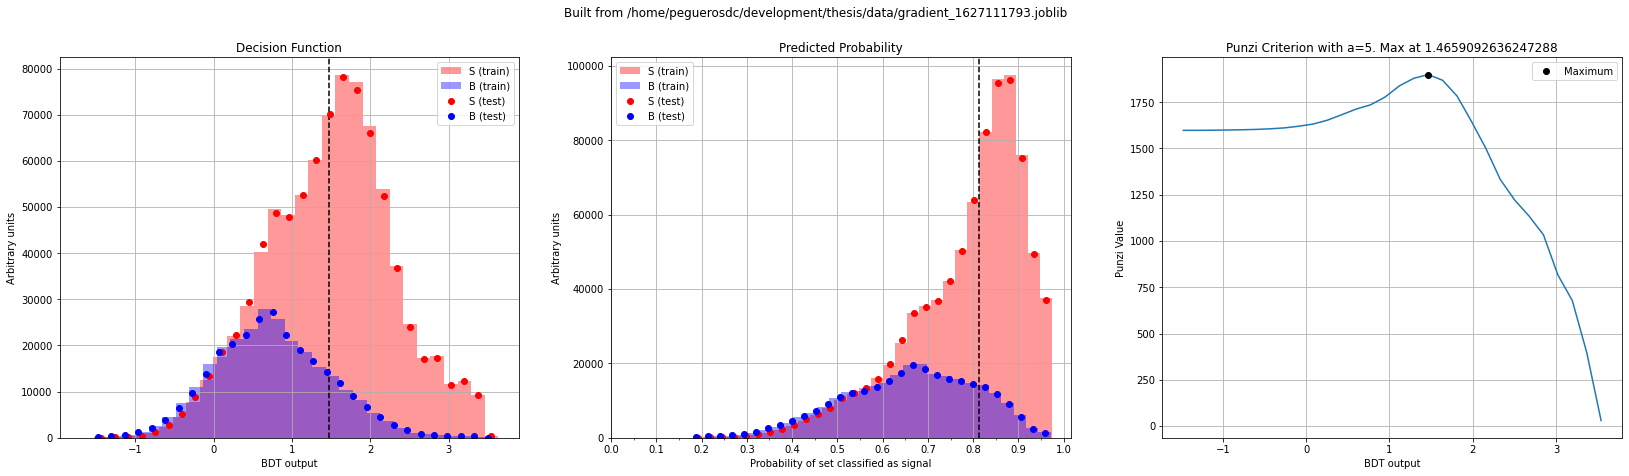

In [7]:
# plot output distribution
fig, axs = plt.subplots(1, 3, figsize=(28, 7))
fig.suptitle(f"Built from {config['tree_to_use']}")
nbins = 30

# Compute the decision function for the training set
def plot_decision_function(ax, data, is_signal=True, is_train=True):
    d_signal = model.decision_function(data).ravel()
    color = "r" if is_signal else "b"
    label = "S" if is_signal else "B"
    set_type = 'train' if is_train else 'test'
    return ax_decision.hist(d_signal, label=f"{label} ({set_type})",
        color=color, alpha=0.4, bins=nbins, histtype='stepfilled', density=False)

ax_decision = axs[0]
d_signal_hist, d_bins, _ = plot_decision_function(ax_decision, features_train[(target_train==1)], is_signal=True, is_train=True)
d_noise_hist, _, _ = plot_decision_function(ax_decision, features_train[(target_train==0)], is_signal=False, is_train=True)

# Compute the decision function for the test set
hist, bins = np.histogram(model.decision_function(features_test[(target_test==1)]).ravel(), bins=nbins)
center = (bins[:-1] + bins[1:]) / 2
ax_decision.errorbar(center, hist, fmt='o', c='r', label='S (test)')

hist, bins = np.histogram(model.decision_function(features_test[(target_test==0)]).ravel(), bins=nbins)
center = (bins[:-1] + bins[1:]) / 2
ax_decision.errorbar(center, hist, fmt='o', c='b', label='B (test)')

ax_decision.grid()
ax_decision.set_title("Decision Function")
ax_decision.set_xlabel("BDT output")
ax_decision.set_ylabel("Arbitrary units")
ax_decision.legend(loc='best')

# Compute the probabilities for the training set
ax_probs = axs[1]
d_signal = model.predict_proba(features_train[(target_train==1)])[:,1]
ax_probs.hist(d_signal,
    color='r', alpha=0.4, bins=nbins,
    histtype='stepfilled', density=False,
    label='S (train)')

d_noise  = model.predict_proba(features_train[(target_train==0)])[:,1]
ax_probs.hist(d_noise,
    color='b', alpha=0.4, bins=nbins,
    histtype='stepfilled', density=False,
    label='B (train)')
# Compute the probabilities for the test set
hist, bins = np.histogram(model.predict_proba(features_test[(target_test==1)])[:,1], bins=nbins)
center = (bins[:-1] + bins[1:]) / 2
ax_probs.errorbar(center, hist, fmt='o', c='r', label='S (test)')

hist, bins = np.histogram(model.predict_proba(features_test[(target_test==0)])[:,1], bins=nbins)
center = (bins[:-1] + bins[1:]) / 2
ax_probs.errorbar(center, hist, fmt='o', c='b', label='B (test)')

ax_probs.grid()
ax_probs.set_title("Predicted Probability")
ax_probs.set_xlabel("Probability of set classified as signal")
ax_probs.set_ylabel("Arbitrary units")
ax_probs.legend(loc='best')
_ = ax_probs.set_xticks(np.arange(0, 1.01, 0.1), minor=False)
_ = ax_probs.set_xticks(np.arange(0.05, 1, 0.1), minor=True)

# Compute Punzi criterion
punzi = []
a_sigmas = 5

# Compute all Punzi values
max_bin, max_punzi = 0, 0
for bin in range(len(d_signal_hist)):
    # Compute Punzi value p
    nsig = sum(d_signal_hist[bin:])
    nbkg = sum(d_noise_hist[bin:])
    p = nsig/(a_sigmas/2 + np.sqrt(nbkg))
    punzi.append(p)
    # Find maximum
    if p > max_punzi:
        max_bin, max_punzi = bin, p
dcenters = (d_bins[:-1] + d_bins[1:]) / 2
best_cut_threshold = dcenters[max_bin]
best_cut_probability = 1.0/(1.0 + np.exp(-1*best_cut_threshold))
print(f"Best Punzi value is {max_punzi} at {best_cut_threshold} with probability {best_cut_probability}")

# Plot
punzi_ax = axs[2]
punzi_ax.plot(dcenters, punzi)
punzi_ax.plot(best_cut_threshold, max_punzi, "ko", label="Maximum")
punzi_ax.set_title(f"Punzi Criterion with a={a_sigmas}. Max at {best_cut_threshold}")
punzi_ax.set_xlabel("BDT output")
punzi_ax.set_ylabel("Punzi Value")
punzi_ax.grid()
_ = punzi_ax.legend(loc='best')

# Show also on the previous axes
_ = ax_decision.axvline(best_cut_threshold, linestyle="--", color="black")
_ = ax_probs.axvline(best_cut_probability, linestyle="--", color="black")

Check how good is the BDT with the default threshold and with the Punzi threshold looking at how much background is left after applying the BDT in the weak version (the default) and in the strict version (with the Punzi criterion)

In [8]:
# helper functions
def get_signal_idx(data):
    return ( ( 
        ( (data.track_sig_charge==1)  & (data.tauPlusMCMode ==4) ) | 
        ( (data.track_sig_charge==-1) & (data.tauMinusMCMode==4) )
    ) == 1 )

def get_background_idx(data):
    return ( ( 
        ( (data.track_sig_charge==1)  & (data.tauPlusMCMode ==4) ) | 
        ( (data.track_sig_charge==-1) & (data.tauMinusMCMode==4) )
    ) == 0 )

In [9]:
import boost_histogram as bh

nbins, rmin, rmax = 50, 0.2, 1.8

def get_mass_histograms(data):
    signal = data[get_signal_idx(data)]
    background = data[get_background_idx(data)]

    mass_signal = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
    mass_signal.fill( signal.tau_sig_InvM )

    mass_noise = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
    mass_noise.fill( background.tau_sig_InvM )

    mass_mc_signal = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
    mass_mc_signal.fill( signal.tau_sig_matchedMC_InvM )

    mass_mc_noise = bh.Histogram(bh.axis.Regular(nbins, rmin, rmax))
    mass_mc_noise.fill( background.tau_sig_matchedMC_InvM )

    return mass_signal, mass_noise, mass_mc_signal, mass_mc_noise

# get weak predictions
weak_prediction = data_test[(model.predict(features_test) == 1)]
weak_mass_signal, weak_mass_noise, weak_mass_mc_signal, weak_mass_mc_noise = get_mass_histograms(weak_prediction)

# get strict prediction
threshold = 0.8124348178431804
strict_prediction = data_test[(model.predict_proba(features_test) >= threshold)]
strict_mass_signal, strict_mass_noise, strict_mass_mc_signal, strict_mass_mc_noise = get_mass_histograms(strict_prediction)


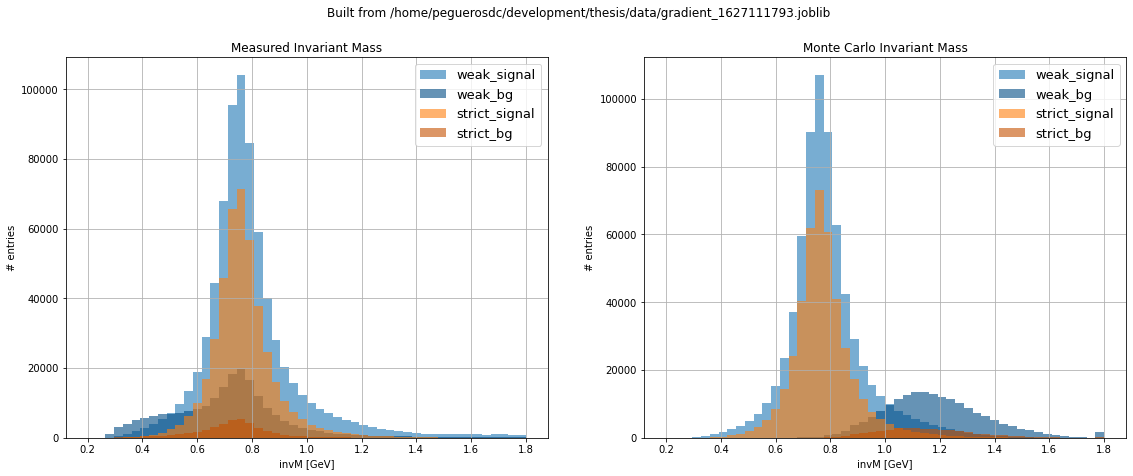

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(19, 7))
fig.suptitle(f"Built from {config['tree_to_use']}")

# Plot the histogram of the data
ax_mass = axs[0]
ax_mass.bar(weak_mass_signal.axes[0].centers, weak_mass_signal.view(), width=weak_mass_signal.axes[0].widths, color='#1f77b4', label="weak_signal", alpha=0.6)
ax_mass.bar(weak_mass_noise.axes[0].centers, weak_mass_noise.view(), width=weak_mass_noise.axes[0].widths, color='#004c84', label="weak_bg", alpha=0.6)
ax_mass.bar(strict_mass_signal.axes[0].centers, strict_mass_signal.view(), width=strict_mass_signal.axes[0].widths, color='#ff7f0e', label="strict_signal", alpha=0.6)
ax_mass.bar(strict_mass_noise.axes[0].centers, strict_mass_noise.view(), width=strict_mass_noise.axes[0].widths, color='#c55000', label="strict_bg", alpha=0.6)
ax_mass.set_title("Measured Invariant Mass")
ax_mass.set_xlabel("invM [GeV]")
ax_mass.set_ylabel("# entries")
ax_mass.legend(prop={"size": 13})
ax_mass.grid()

# Plot the histogram of the monte carlo
ax_mass_mc = axs[1]
ax_mass_mc.bar(weak_mass_mc_signal.axes[0].centers, weak_mass_mc_signal.view(), width=weak_mass_mc_signal.axes[0].widths, color='#1f77b4', label="weak_signal", alpha=0.6)
ax_mass_mc.bar(weak_mass_mc_noise.axes[0].centers, weak_mass_mc_noise.view(), width=weak_mass_mc_noise.axes[0].widths, color='#004c84', label="weak_bg", alpha=0.6)
ax_mass_mc.bar(strict_mass_mc_signal.axes[0].centers, strict_mass_mc_signal.view(), width=strict_mass_mc_signal.axes[0].widths, color='#ff7f0e', label="strict_signal", alpha=0.6)
ax_mass_mc.bar(strict_mass_mc_noise.axes[0].centers, strict_mass_mc_noise.view(), width=strict_mass_mc_noise.axes[0].widths, color='#c55000', label="strict_bg", alpha=0.6)
ax_mass_mc.set_title("Monte Carlo Invariant Mass")
ax_mass_mc.set_xlabel("invM [GeV]")
ax_mass_mc.set_ylabel("# entries")
ax_mass_mc.legend(prop={"size": 13})
ax_mass_mc.grid()

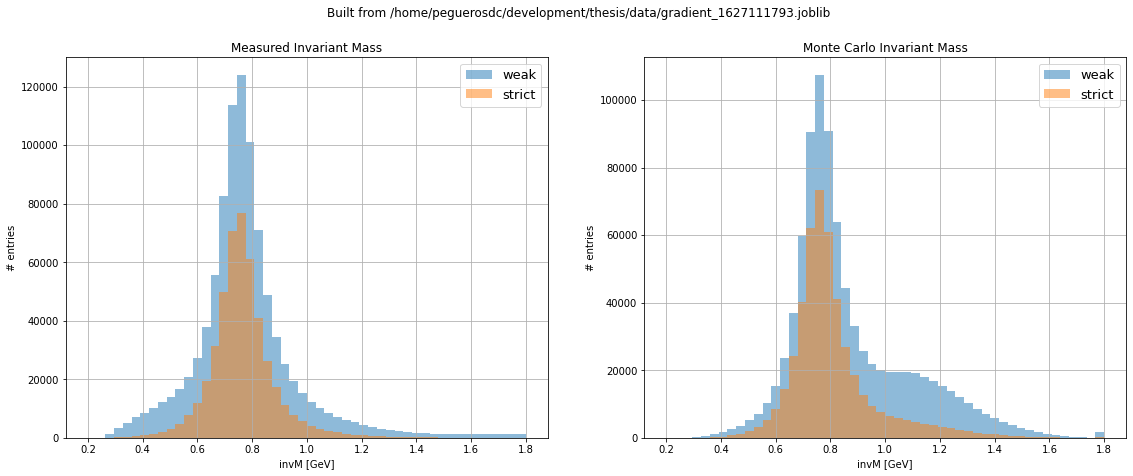

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(19, 7))
fig.suptitle(f"Built from {config['tree_to_use']}")


weak_mass = weak_mass_signal + weak_mass_noise
strict_mass = strict_mass_signal + strict_mass_noise
# Plot the histogram of the data
ax_mass = axs[0]
ax_mass.bar(weak_mass.axes[0].centers, weak_mass.view(), width=weak_mass.axes[0].widths, label="weak", alpha=0.5)
ax_mass.bar(strict_mass.axes[0].centers, strict_mass.view(), width=strict_mass.axes[0].widths, label="strict", alpha=0.5)
ax_mass.set_title("Measured Invariant Mass")
ax_mass.set_xlabel("invM [GeV]")
ax_mass.set_ylabel("# entries")
ax_mass.legend(prop={"size": 13})
ax_mass.grid()

weak_mass_mc = weak_mass_mc_signal + weak_mass_mc_noise
strict_mass_mc = strict_mass_mc_signal + strict_mass_mc_noise
# Plot the histogram of the monte carlo
ax_mass_mc = axs[1]
ax_mass_mc.bar(weak_mass_mc.axes[0].centers, weak_mass_mc.view(), width=weak_mass_mc.axes[0].widths, label="weak", alpha=0.5)
ax_mass_mc.bar(strict_mass_mc.axes[0].centers, strict_mass_mc.view(), width=strict_mass_mc.axes[0].widths, label="strict", alpha=0.5)
ax_mass_mc.set_title("Monte Carlo Invariant Mass")
ax_mass_mc.set_xlabel("invM [GeV]")
ax_mass_mc.set_ylabel("# entries")
ax_mass_mc.legend(prop={"size": 13})
ax_mass_mc.grid()